In [1]:
%matplotlib inline

import pandas as pd
import pylab as plt
import numpy as np
import scipy as sc
import scipy.stats
import math

# Modeling

In this notebook, we will try to build a model for predicting yield in the Univeristy of California system. We will try to achieve the goal by:
 - predicting the yield for each high school
 - combining the predicted yields into a single yield for all high schools
 
In other words, we will try to predict the `yield` column given other columns (besides the data about enrolled students).

## Loading the data

### Incorporating the New Dataset

First, we will load our data. Our dataset contains some extra columns for schools in California:
 - AP scores
 - SAT scores
 - Senior class enrollment
 - Distances to UC campuses
 
That is why we will only perform our modelling in the state of California. Moreover, since our ethnicty data is very erratic, we will only use the cumulative data (`data['ethnicity'] == 'All'`).

In [49]:
data = pd.read_csv("data/with_scores.csv")
data = data[data['state']=='California']
data = data[data['campus'] != 'Universitywide']
data = data[data['ethnicity'] == 'All']

## Choosing the features

The overall plan is to select the newly added features i.e. various test scores, combining with our old features, and generate a linear regression model to make predictions.

First of all, we should take a look of the new dataset. We have a large number of NaNs in the test-score fields, so we might need to drop them if needed. 

In [50]:
data.columns

Index(['campus', 'year', 'school', 'school_num', 'city', 'county', 'state',
       'country', 'region', 'ethnicity', 'app_num', 'adm_num', 'enr_num',
       'app_gpa', 'adm_gpa', 'enr_gpa', 'distance', 'ap_num_scr1',
       'ap_num_scr2', 'ap_num_scr3', 'ap_num_scr4', 'ap_num_scr5',
       'ap_num_test_takers', 'enroll12', 'school_name', 'sat_math_avg',
       'sat_num_test_takers', 'sat_total_avg', 'sat_verbal_avg', 'yield'],
      dtype='object')

check how many NaN's are there in each field 

In [51]:
count_nan = len(data) - data.count()
count_nan

campus                     0
year                       0
school                     0
school_num             24423
city                       0
county                     0
state                      0
country                    0
region                     0
ethnicity                  0
app_num                    0
adm_num                25145
enr_num                69450
app_gpa                    0
adm_gpa                25145
enr_gpa                69450
distance                  23
ap_num_scr1            42130
ap_num_scr2            42133
ap_num_scr3            42135
ap_num_scr4            42151
ap_num_scr5            42212
ap_num_test_takers     40769
enroll12               40229
school_name            40229
sat_math_avg           41000
sat_num_test_takers    40739
sat_total_avg          41000
sat_verbal_avg         41000
yield                  69450
dtype: int64

After careful consideration we decided to use the features in `train_cols` below for training. Some of the factors we considered:

- We should not include all of `sat_total_avg`, `sat_math_avg`, `sat_verbal_avg` - since each is a linear combination of the other two.
- We must not use the `enr_*` fields since that would cause bleeding of the predicted column into the training set. Moreover, no enrollment data will be available at the time of the prediction - modelling yield is only interesting if we don't know who accepted the admission offer.

In [52]:
train_cols = [
    'year', 
    'app_num', 'adm_num', 
    'app_gpa', 'adm_gpa',
    'distance',
    'ap_num_scr1', 'ap_num_scr2', 'ap_num_scr3', 'ap_num_scr4', 'ap_num_scr5',
    'ap_num_test_takers',
    'enroll12',
    'sat_total_avg', 'sat_num_test_takers'
]
pred_col = ['yield']

def get_data_for_campus(df, campus_name):
     return df[df['campus'] == campus_name].dropna()
    

Next, we will inspect example training and testing data.

In [53]:
berkeley_data = get_data_for_campus(data, 'Berkeley')
berkeley_data[train_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
year,1533.0,2006.438356,5.123120,1998.000000,2002.000000,2006.000000,2011.000000,2015.000000
app_num,1533.0,76.707110,46.185257,11.000000,43.000000,68.000000,97.000000,308.000000
adm_num,1533.0,19.054142,11.516321,5.000000,11.000000,16.000000,24.000000,86.000000
app_gpa,1533.0,3.849583,0.117607,3.271579,3.774948,3.855942,3.932885,4.112941
adm_gpa,1533.0,4.162445,0.096072,3.495000,4.116304,4.181429,4.229286,4.362500
distance,1533.0,358743.354207,292128.519051,662.000000,51515.000000,302470.000000,634670.000000,958441.000000
ap_num_scr1,1533.0,83.444879,73.315471,0.000000,34.000000,62.000000,113.000000,581.000000
ap_num_scr2,1533.0,140.981083,85.277999,0.000000,80.000000,127.000000,183.000000,571.000000
ap_num_scr3,1533.0,203.210046,126.119971,0.000000,105.000000,181.000000,279.000000,732.000000
ap_num_scr4,1533.0,189.658187,140.994974,0.000000,82.000000,158.000000,268.000000,796.000000


In [54]:
berkeley_data[pred_col].describe()

,yield
count,1533.000000
mean,0.552133
std,0.173931
min,0.178571
25%,0.428571
50%,0.529412
75%,0.666667
max,1.000000


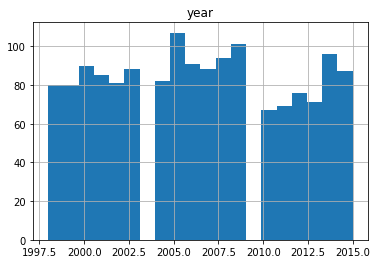

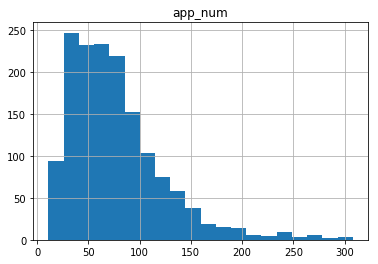

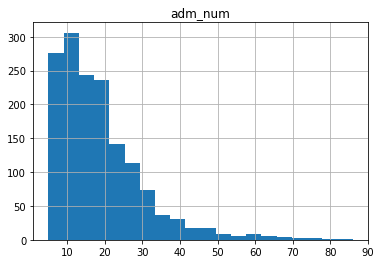

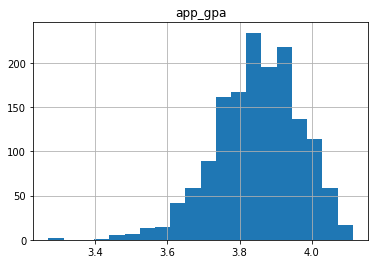

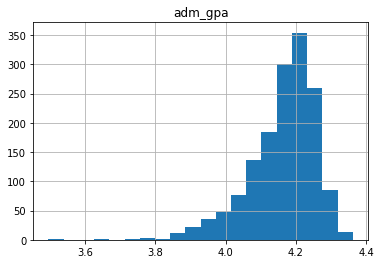

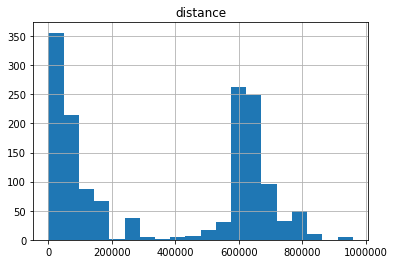

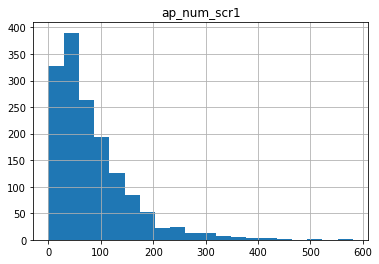

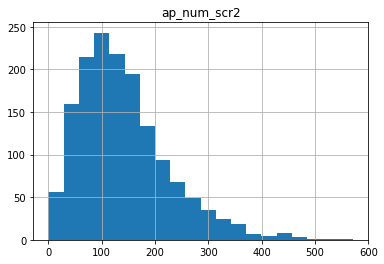

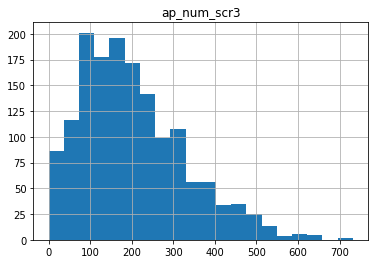

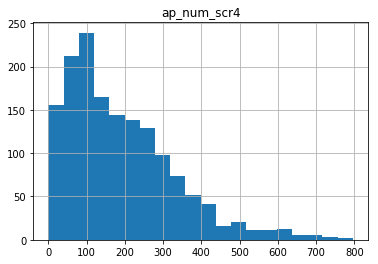

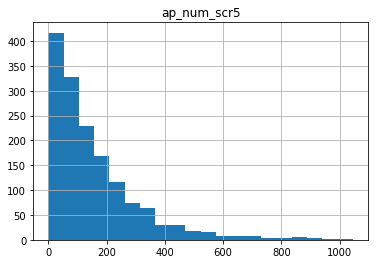

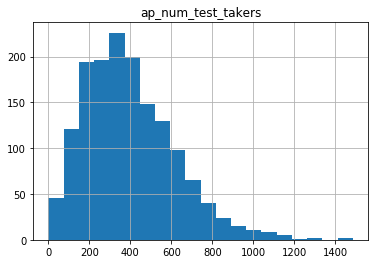

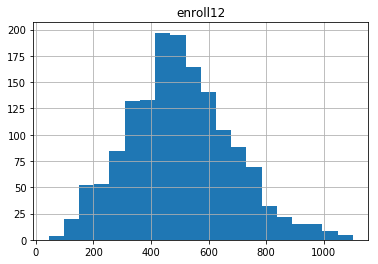

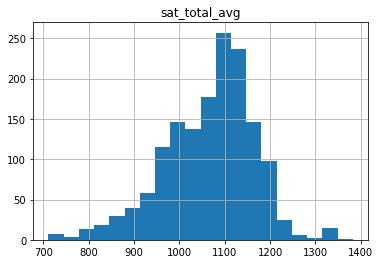

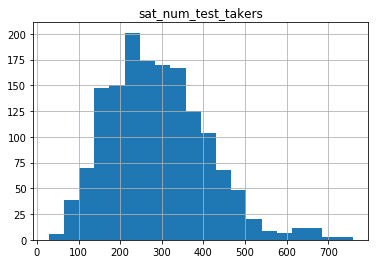

In [55]:
for col in train_cols:
    plt.figure()
    plt.title(col)
    berkeley_data[col].hist(bins=20)

## Using Z-scores in our model

To make sure all of our data is on the same scale, we will prepare Z-Scoring functions. However, our predictions will then be outputed on the Z-Score scale, thus we will also need a function to undo the Z-Scores.

In [56]:
def z_score(X):
    return (X-X.mean(axis=0)) / X.std(axis=0)

def z_score_from_different_data_sample(X, diff_sample):
    return (X-diff_sample.mean(axis=0)) / diff_sample.std(axis=0)

def undo_z_score(to_undo, orig_sample):
    return (to_undo * orig_sample.std(axis=0)) + orig_sample.mean(axis=0)

We will now see the distribution of our data when Z-scored (shown on the data from UC Berkeley)

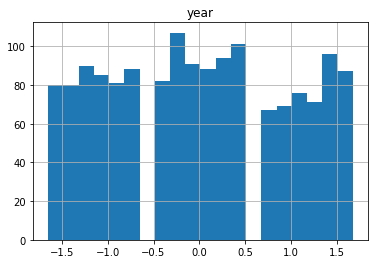

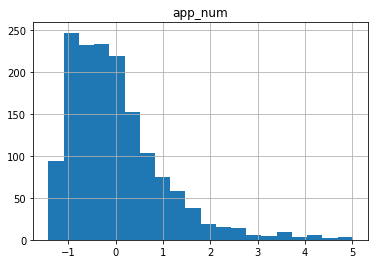

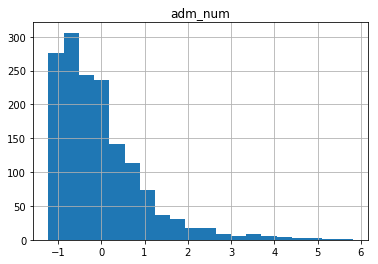

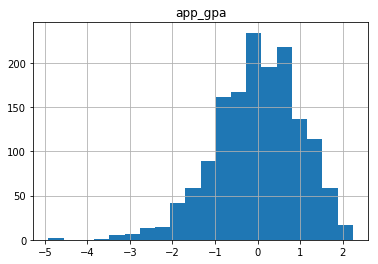

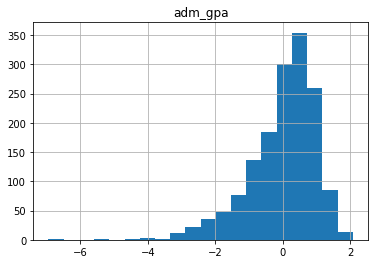

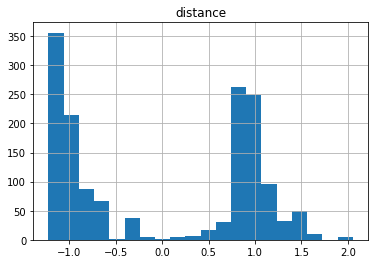

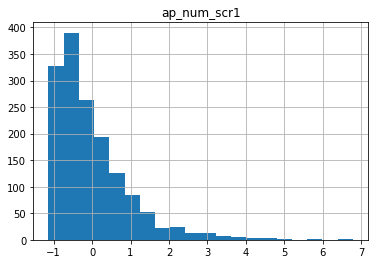

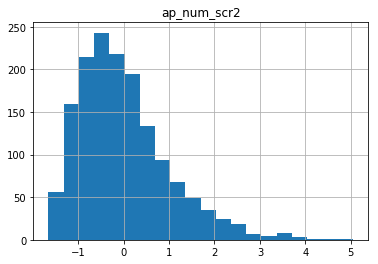

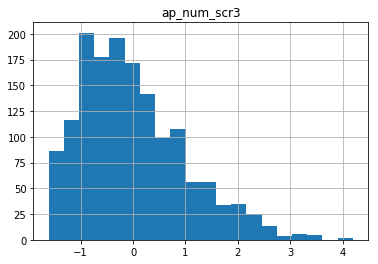

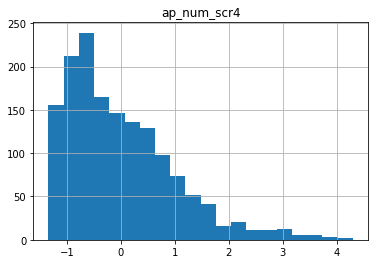

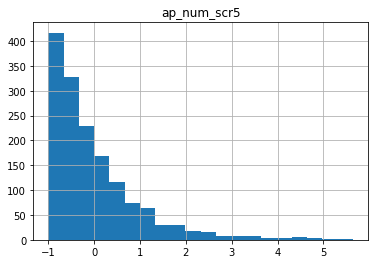

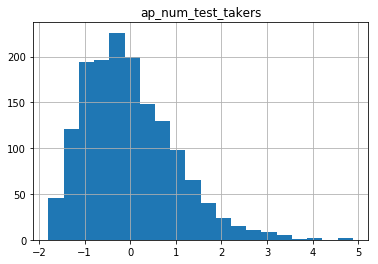

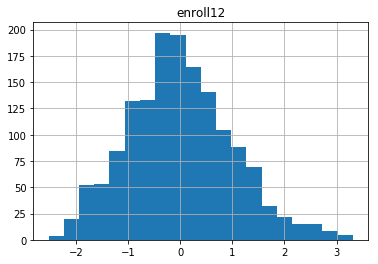

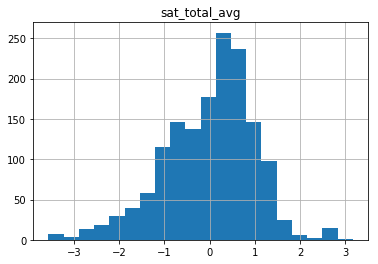

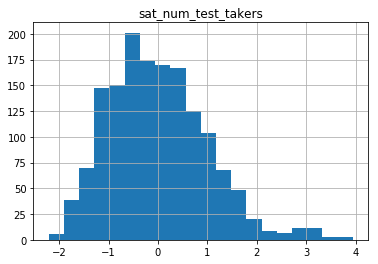

In [57]:
for col in train_cols:
    plt.figure()
    plt.title(col)
    z_score(berkeley_data[train_cols])[col].hist(bins=20)

## Splitting the data into train and test sets
We will use all early years for training, and later years for testing. This is done because universities would train and evaluate this way - only past data is available to train on.

Note that we are using the data from the training set to compute the Z-scores for both the training data and the test data. We do that to avoid our testing data bleeding into our training data.

In [58]:
def get_training_split(df, split_ratio):
    years = df['year'].unique()
    cutoff_year = years[int(math.ceil(len(years)*split_ratio))]
    
    train_filter = df['year'] <= cutoff_year
    test_filter = df['year'] > cutoff_year
    
    inputs_training_set = df[train_cols][train_filter]
    inputs_test_set = df[train_cols][test_filter]
    
    outputs_training_set = df[pred_col][train_filter]
    outputs_test_set = df[pred_col][test_filter]
    
    result = {
        'original': df,
        'train_filter': train_filter,
        'test_filter': test_filter,
        'inputs_training_set': inputs_training_set,
        'inputs_test_set': inputs_test_set,
        'outputs_training_set': outputs_training_set,
        'outputs_test_set': outputs_test_set,
        'z_inputs_training_set': z_score_from_different_data_sample(inputs_training_set, inputs_training_set),
        'z_inputs_test_set': z_score_from_different_data_sample(inputs_test_set, inputs_training_set),
        'z_outputs_training_set': z_score_from_different_data_sample(outputs_training_set, outputs_training_set),
        'z_outputs_test_set': z_score_from_different_data_sample(outputs_test_set, outputs_training_set),
    }
    return result

## Helpers for extracting yield data from the dataset 

We have prepared a few helpers to aid the process of extracting yield data from our dataset. For example, we can build a chart, that shows the yield of each UC campus by year.

Using the chart shown below, we have also found out that UC Merced was founded in 2005 (and that is why it is missing data from previous years).

In [59]:
def hs_name_to_code(hs_name):
    return list(df[df['school'] == hs_name]['school_num'])[0]
    
def get_hs_yield_on_campus_filtered_df(df, hs_code, year):
    data_filter = (df['school_num'] == hs_code) & (df['year'] == year)
    _yield = df[data_filter]['yield']
    try:
        return list(_yield)[0]
    except IndexError:
        return np.nan

def get_hs_yield(df, hs_code, uc_campus, year):
    return get_hs_yield_on_campus_filtered_df(
        df[df['campus'] == uc_campus],
        hs_code, year
    )
    
def get_year_yields(df):
    campuses = df['campus'].unique()
    yields = {}
    for campus in campuses:
        df_for_campus = df[df['campus'] == campus]
        enrolled_and_admitted = df_for_campus.groupby('year')[['enr_num', 'adm_num']].sum()
        yields[campus] = enrolled_and_admitted['enr_num']/enrolled_and_admitted['adm_num']
    
    return pd.DataFrame(yields)

In [60]:
get_year_yields(data.dropna())

,Berkeley,Davis,Irvine,Los Angeles,Merced,Riverside,San Diego,Santa Barbara,Santa Cruz
year,,,,,,,,,
1998.0,0.507627,0.363409,0.332733,0.473203,NaN,0.345988,0.297352,0.303652,0.276444
1999.0,0.502868,0.332334,0.338978,0.485569,NaN,0.291554,0.299541,0.318915,0.275777
2000.0,0.501428,0.347982,0.330483,0.472302,NaN,0.288559,0.274460,0.312261,0.256981
2001.0,0.500295,0.332691,0.304998,0.466802,NaN,0.290730,0.289132,0.283830,0.221849
2002.0,0.507080,0.326146,0.315193,0.492867,NaN,0.297595,0.293932,0.276820,0.208574
2003.0,0.495575,0.348144,0.306728,0.485891,NaN,0.261145,0.292667,0.281797,0.261941
2004.0,0.493590,0.353061,0.287456,0.434617,NaN,0.309609,0.305804,0.275111,0.249534
2005.0,0.491837,0.298534,0.286117,0.468901,0.239521,0.263701,0.275202,0.271497,0.228916
2006.0,0.503037,0.324640,0.262264,0.459245,0.157895,0.240594,0.274266,0.277700,0.215624


## Model evaluation

We will evaluate our models in two main ways:
- Root mean square as measured for each datapoint in the test dataset
- Accuracy of the prediction extended for the entire academic year

In [61]:
def rms_evaluate_model(df, hs_codes, years, predictions):
    assert(len(hs_codes) == len(years) == len(predictions))
    
    hs_codes = list(hs_codes)
    years = list(years)
    predictions = list(predictions)
    
    square_error_sum = 0
    for i in range(len(hs_codes)):
        expected = get_hs_yield_on_campus_filtered_df(df, hs_codes[i], years[i])
        square_error_sum += (expected - predictions[i])**2
    
    return (square_error_sum / len(hs_codes))**(.5)

def predictions_to_yearly(df, hs_codes, years, predictions):
    """
    Converts a model prediction (prediction by high school) into yearly predictions.
    """
    assert(len(hs_codes) == len(years) == len(predictions))
    
    hs_codes = list(hs_codes)
    years = list(years)
    predictions = list(predictions)
    
    adm_and_enr_by_year = {}
    for i in range(len(hs_codes)):
        if years[i] in adm_and_enr_by_year:
            adm_and_enr = adm_and_enr_by_year[years[i]]
        else:
            adm_and_enr = {'adm': 0, 'enr': 0}
            adm_and_enr_by_year[years[i]] = adm_and_enr
        admitted_count = df[(df['school_num'] == hs_codes[i]) & (df['year'] == years[i])]['adm_num'].values[0]
        adm_and_enr['adm'] += admitted_count
        adm_and_enr['enr'] += admitted_count * predictions[i]
    return adm_and_enr_by_year


def evaluate_yearly_predictions(yearly_preds, expected_yields):
    """
    Evaluates the yearly predictions returned by predictions_to_yearly() given the actual
    yield by year information.
    """
    result = {}
    for year in yearly_preds:
        result[year] = {
            'expected': list(expected_yields[expected_yields.index == year].values)[0][0],
            'predicted': yearly_preds[year]['enr']/yearly_preds[year]['adm'],
            'adm': yearly_preds[year]['adm'],
            'predicted_enr': yearly_preds[year]['enr'],
        }
        result[year]['rms'] = ((result[year]['expected'] - result[year]['predicted'])**2)
    return result

## Baseline model

We created a baseline model to which we could compare other models. The baseline model that we used was to simply take the average yield for the past N years for each high school for each campus. For the initial years, if there wasn’t enough data to compute this, then the baseline just predicted a yield of 45%, the average yield for all schools for all years.

In [ ]:
def get_baseline_pred_for_hs(df, hs_code, year):
    PAST_YEARS_CNT = 10
    DEFAULT_PREDICTION = 0.45
    prev_years_data = df[(df['school_num'] == hs_code) & (df['year'] < year) & (df['year'] > (year - PAST_YEARS_CNT))]
    prediction = prev_years_data['yield'].mean()
    if math.isnan(prediction):
        return DEFAULT_PREDICTION
    else:
        return prediction
    
def baseline_pred(df, hs_codes, years):
    assert(len(hs_codes) == len(years))
    predictions = []
    for i in range(len(hs_codes)):
        predictions.append(get_baseline_pred_for_hs(df, hs_codes.values[i], years.values[i]))
    return predictions


Now, we will see how our baseline model does on each of the UC campuses:

'Berkeley'

,adm,expected,predicted,predicted_enr,rms
1998.0,1630.0,0.507627,0.450000,733.500000,3.320825e-03
1999.0,1557.0,0.502868,0.499878,778.310683,8.938065e-06
2000.0,1733.0,0.501428,0.507318,879.182061,3.469475e-05
2001.0,1673.0,0.500295,0.503019,841.551511,7.420715e-06
2002.0,1471.0,0.507080,0.509674,749.729965,6.725853e-06
2003.0,1580.0,0.495575,0.507319,801.564142,1.379181e-04
2004.0,1562.0,0.493590,0.508287,793.944757,2.160181e-04
2005.0,1977.0,0.491837,0.503498,995.415830,1.359885e-04
2006.0,1823.0,0.503037,0.512463,934.220384,8.885301e-05
2007.0,1741.0,0.492614,0.500630,871.596433,6.425843e-05


'Davis'

,adm,expected,predicted,predicted_enr,rms
1998.0,2762.0,0.363409,0.450000,1242.900000,0.007498
1999.0,3003.0,0.332334,0.368454,1106.468628,0.001305
2000.0,3288.0,0.347982,0.360071,1183.912336,0.000146
2001.0,3680.0,0.332691,0.366898,1350.185447,0.001170
2002.0,4127.0,0.326146,0.346488,1429.954884,0.000414
2003.0,3850.0,0.348144,0.343793,1323.602841,0.000019
2004.0,3500.0,0.353061,0.347726,1217.041794,0.000028
2005.0,3822.0,0.298534,0.335625,1282.757387,0.001376
2006.0,5074.0,0.324640,0.331517,1682.117783,0.000047
2007.0,4448.0,0.311968,0.342532,1523.580651,0.000934


'Irvine'

,adm,expected,predicted,predicted_enr,rms
1998.0,2774.0,0.332733,0.450000,1248.300000,0.013752
1999.0,3260.0,0.338978,0.352312,1148.536597,0.000178
2000.0,3257.0,0.330483,0.343729,1119.525780,0.000175
2001.0,4166.0,0.304998,0.345310,1438.561073,0.001625
2002.0,3612.0,0.315193,0.329825,1191.327319,0.000214
2003.0,3893.0,0.306728,0.323414,1259.051803,0.000278
2004.0,3741.0,0.287456,0.317807,1188.914521,0.000921
2005.0,4707.0,0.286117,0.317757,1495.684065,0.001001
2006.0,5953.0,0.262264,0.302856,1802.902419,0.001648
2007.0,5467.0,0.300167,0.306362,1674.881780,0.000038


'Los Angeles'

,adm,expected,predicted,predicted_enr,rms
1998.0,2295.0,0.473203,0.450000,1032.750000,5.383613e-04
1999.0,2341.0,0.485569,0.464426,1087.221400,4.470139e-04
2000.0,2405.0,0.472302,0.480568,1155.766353,6.832873e-05
2001.0,2430.0,0.466802,0.482339,1172.084441,2.413932e-04
2002.0,2155.0,0.492867,0.480114,1034.645434,1.626419e-04
2003.0,2316.0,0.485891,0.482125,1116.601714,1.417944e-05
2004.0,1842.0,0.434617,0.460162,847.617884,6.525085e-04
2005.0,2530.0,0.468901,0.478180,1209.794316,8.608347e-05
2006.0,2640.0,0.459245,0.472663,1247.830089,1.800328e-04
2007.0,2401.0,0.442194,0.476776,1144.738535,1.195890e-03


'Merced'

,adm,expected,predicted,predicted_enr,rms
2005.0,167.0,0.239521,0.450000,75.150000,0.044301
2006.0,171.0,0.157895,0.450742,77.076923,0.085760
2007.0,335.0,0.259701,0.428518,143.553584,0.028499
2008.0,463.0,0.213823,0.309403,143.253402,0.009135
2009.0,633.0,0.218009,0.375163,237.478358,0.024697
2010.0,812.0,0.200957,0.324250,263.290665,0.015201
2011.0,560.0,0.307143,0.309086,173.088203,0.000004
2012.0,745.0,0.315646,0.306667,228.466981,0.000081
2013.0,797.0,0.355082,0.353995,282.133979,0.000001
2014.0,631.0,0.334390,0.355838,224.533468,0.000460


'Riverside'

,adm,expected,predicted,predicted_enr,rms
1998.0,2081.0,0.345988,0.450000,936.450000,0.010819
1999.0,2593.0,0.291554,0.368126,954.549450,0.005863
2000.0,3160.0,0.288559,0.346694,1095.551614,0.003380
2001.0,3224.0,0.290730,0.322993,1041.329478,0.001041
2002.0,3525.0,0.297595,0.316564,1115.887258,0.000360
2003.0,4243.0,0.261145,0.303181,1286.398873,0.001767
2004.0,3091.0,0.309609,0.293901,908.447498,0.000247
2005.0,3330.0,0.263701,0.301972,1005.567155,0.001465
2006.0,4960.0,0.240594,0.298949,1482.786502,0.003405
2007.0,4846.0,0.248802,0.285708,1384.538892,0.001362


'San Diego'

,adm,expected,predicted,predicted_enr,rms
1998.0,2478.0,0.297352,0.450000,1115.100000,2.330156e-02
1999.0,2618.0,0.299541,0.320156,838.169317,4.249953e-04
2000.0,2723.0,0.274460,0.312499,850.935173,1.447014e-03
2001.0,3456.0,0.289132,0.289398,1000.158869,7.049345e-08
2002.0,3795.0,0.293932,0.305028,1157.579865,1.231080e-04
2003.0,3144.0,0.292667,0.308000,968.352881,2.351001e-04
2004.0,3020.0,0.305804,0.304821,920.559801,9.666541e-07
2005.0,3356.0,0.275202,0.300531,1008.583638,6.415868e-04
2006.0,4244.0,0.274266,0.296580,1258.684785,4.979261e-04
2007.0,3782.0,0.288217,0.294761,1114.785226,4.282666e-05


'Santa Barbara'

,adm,expected,predicted,predicted_enr,rms
1998.0,1533.0,0.303652,0.450000,689.850000,0.021418
1999.0,1539.0,0.318915,0.343627,528.841500,0.000611
2000.0,1564.0,0.312261,0.309826,484.567691,0.000006
2001.0,1724.0,0.283830,0.314091,541.492520,0.000916
2002.0,2061.0,0.276820,0.316534,652.377400,0.001577
2003.0,2115.0,0.281797,0.326209,689.932313,0.001972
2004.0,2206.0,0.275111,0.313118,690.737713,0.001445
2005.0,2291.0,0.271497,0.307607,704.727068,0.001304
2006.0,2052.0,0.277700,0.312250,640.737633,0.001194
2007.0,2641.0,0.241140,0.301625,796.592504,0.003658


'Santa Cruz'

,adm,expected,predicted,predicted_enr,rms
1998.0,1125.0,0.276444,0.450000,506.250000,0.030122
1999.0,1223.0,0.275777,0.305395,373.498089,0.000877
2000.0,2295.0,0.256981,0.334962,768.737523,0.006081
2001.0,2729.0,0.221849,0.284446,776.253814,0.003918
2002.0,3289.0,0.208574,0.261851,861.227133,0.002838
2003.0,2612.0,0.261941,0.256097,668.925905,0.000034
2004.0,2784.0,0.249534,0.255937,712.529872,0.000041
2005.0,2912.0,0.228916,0.250195,728.566941,0.000453
2006.0,3512.0,0.215624,0.257693,905.016588,0.001770
2007.0,3311.0,0.237298,0.250886,830.682101,0.000185


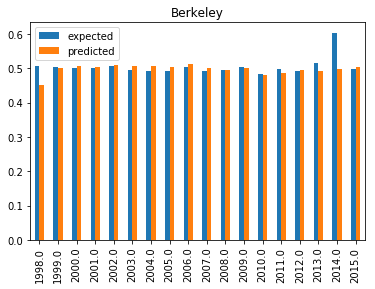

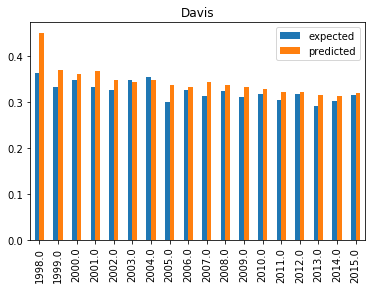

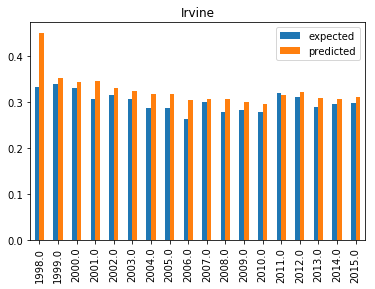

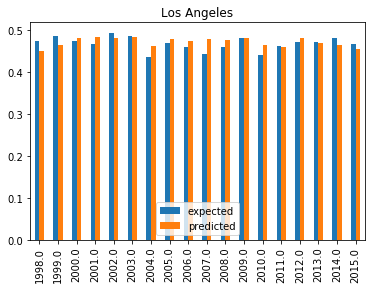

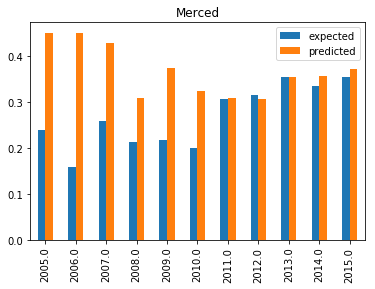

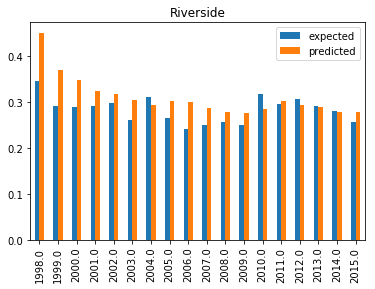

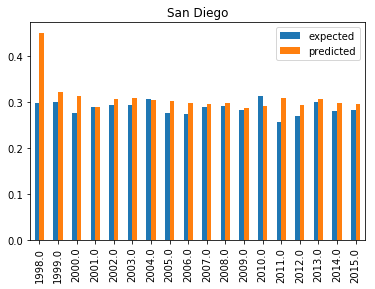

In [ ]:
for campus in data['campus'].unique():
    campus_data = get_data_for_campus(data, campus)
    data_split = get_training_split(campus_data, .7)
    base_pred = baseline_pred(
        campus_data,
        campus_data['school_num'],
        campus_data['year']
    )
    
    yearly = predictions_to_yearly(campus_data, campus_data['school_num'], campus_data['year'], base_pred)
    result_matrix = pd.DataFrame(evaluate_yearly_predictions(yearly, get_year_yields(campus_data))).T
    display(campus, result_matrix)
    result_matrix[['expected','predicted']].plot(kind='bar', title=campus)

## Preparing and fitting a linear regressor

### Choosing the model

We are performing a regression, so that means we should not use classification algorithms such as nearest neighbors, logistic regression, SVMs, or decision trees. Two remaining possibilities would have been to use linear regression or a neural network, but we don’t think this problem is complex enough to warrant the added difficulties, complications, and lack of interpretability that a neural network would add. Thus, we decided to use a simple linear regression model. It was a good choice because it was fast to run over our many different experiments that we performed, easy to understand how it behaved so we could better troubleshoot with our rapid development schedule, and descriptive enough to adequately predict the relatively simple problem we were tackling.

### Other possible models

- **Using wide datapoints** - one for each year. The datapoints would include the following features:
  - For each school:
      - Number of applied
      - Number of accepted
      - GPA of applied
      - GPA of accepted
      - SAT scores
      - AP scores
      - High school enrollment
      - High school distance from the UC campus
  - Year
  
 We decided against using that model. One of the main reasons was insufficient time to experiment with combined features (we believe that we should multiply each feature but the number of accepted students).

- **Wide datapoints with random sampling.** - as above, but we would generate random datapoints where only sum of the high schools will be set. This way, we can overcome one of the most significant problems of the model above - an extremely small number of datapoints.

- Using this method above, we should be able to create enough data points for running a Neural Net
  


In [ ]:
from sklearn.linear_model import LinearRegression

def prepare_linear_reg_model(data_split):
    reg = LinearRegression()
    reg.fit(data_split['z_inputs_training_set'], data_split['z_outputs_training_set'])    
    return reg

def evaluate_linear_reg_model(reg, data_split):
    y_pred = reg.predict(data_split['z_inputs_test_set'])
    eval_result = pd.DataFrame(data={
        'z-actual':data_split['z_outputs_test_set'].values.flatten(),
        'z-predicted':y_pred.flatten(),
        'school_num': data_split['original']['school_num'][data_split['test_filter']].values.flatten(),
        'year': data_split['original']['year'][data_split['test_filter']].values.flatten(),
        'predicted': undo_z_score(y_pred.flatten(), data_split['outputs_training_set']['yield'])
    })
    return eval_result

def extract_yearly_predictions(d_split, eval_results):
    yearly = predictions_to_yearly(
        d_split['original'],
        eval_results['school_num'],
        eval_results['year'],
        eval_results['predicted']
    )
    yearly_eval_res = evaluate_yearly_predictions(yearly, get_year_yields(d_split['original']))
    return pd.DataFrame(yearly_eval_res).T

In [ ]:
regressor_results = {}

for campus in data['campus'].unique():
    campus_resuts = {}
    regressor_results[campus] = campus_resuts
    
    d_split = get_training_split(get_data_for_campus(data, campus), .7)
    
    model = prepare_linear_reg_model(d_split)
    per_school_results = evaluate_linear_reg_model(model, d_split)
    display(campus, per_school_results)
    campus_resuts['per_school'] = per_school_results
    
    yearly_pred_eval = extract_yearly_predictions(d_split, per_school_results)
    campus_resuts['yearly'] = yearly_pred_eval
    display(campus, yearly_pred_eval)
    yearly_pred_eval[['expected', 'predicted']].plot.bar(title=campus)
    
    print('Regressor score for', campus, model.score(
        data_split['z_inputs_test_set'], data_split['z_outputs_test_set']
    ))


In [ ]:
for campus in regressor_results:
    plt.scatter(
        regressor_results[campus]['per_school']['z-actual'].values.flatten(),
        regressor_results[campus]['per_school']['z-predicted'].values.flatten(),
        alpha=.1
    )
    plt.title(campus)
    plt.show()

In [ ]:
# import statsmodels.api as sm
# X_train2 = sm.add_constant(X_train)
# est = sm.OLS(y_train, X_train2)
# est2 = est.fit()
# est2.summary()

## Results

Both our baseline model and linear regression model suggested us that the yield rate would stay at around 45% - 50%, which is a solid prediction. 
